In [1]:
import tensorflow as tf
from captcha.image import ImageCaptcha
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
def random_captcha_text(char_set=alphabet,captcha_size=4):
    captcha_text = []
    for i in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    return captcha_text

print(random_captcha_text())

['h', 'q', 'v', 'n']


In [3]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 128
def gen_captcha_text_and_image():
    image =  ImageCaptcha()
    captcha_text = random_captcha_text()
    captcha_text =  ''.join(captcha_text)
    
    captcha = image.generate(captcha_text)
    # 变成灰度图像convert('L')
    captcha_image = Image.open(captcha).convert('L')
    # 裁剪缩放图片
    box = (0,0,128,60)
    captcha_image = captcha_image.crop(box)
    captcha_image = captcha_image.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
    # 转化成 np.array类型
    captcha_image = np.array(captcha_image)
    return captcha_text, captcha_image


In [4]:
MAX_CAPTCHA = 4
CHAR_SET_LEN = len(alphabet)

def text2vec(text):
    text_len = len(text)
    if text_len > len(text):
        raise ValueError('验证码最长4个字符')
    
    vector = np.zeros(MAX_CAPTCHA * CHAR_SET_LEN)
    
    for i,c in enumerate(text):
        idx = i * CHAR_SET_LEN + ord(c) - 97
        vector[idx] =  1
    return vector
    
def vec2text(vec):
    text = []
    for i,c in enumerate(vec):
        if c == 1:
            idx = i % CHAR_SET_LEN
            text.append(chr(idx+97))
    return text

print(vec2text(text2vec('abcd')))

['a', 'b', 'c', 'd']


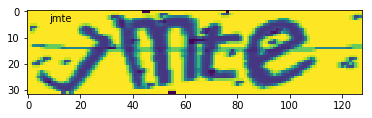

In [5]:
def plt_image(image):
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.text(0.1, 0.9, text, ha='center', va='center', transform=ax.transAxes)
    plt.imshow(image)
    plt.show()

if __name__== '__main__':
    text, image = gen_captcha_text_and_image()
    plt_image(image)

In [6]:
# 生成一个训练batch
def get_next_batch(batch_size=128):
    batch_x = np.zeros([batch_size, IMAGE_HEIGHT * IMAGE_WIDTH])
    batch_y = np.zeros([batch_size, MAX_CAPTCHA * CHAR_SET_LEN])
    
    for i in range(batch_size):
        text, image = gen_captcha_text_and_image()
        batch_x[i, :] = image.flatten() / 255  # (image.flatten()-128)/128  mean为0
        batch_y[i, :] = text2vec(text)
    
    return batch_x, batch_y

In [7]:
#####################################

X = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT * IMAGE_WIDTH])
Y = tf.placeholder(tf.float32, [None, MAX_CAPTCHA * CHAR_SET_LEN])
keep_prob = tf.placeholder(tf.float32)  # dropout

In [68]:
# 定义CNN
def crack_captcha_cnn(w_alpha=0.01, b_alpha=0.1):
    x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

    # w_c1_alpha = np.sqrt(2.0/(IMAGE_HEIGHT*IMAGE_WIDTH)) #
    # w_c2_alpha = np.sqrt(2.0/(3*3*32))
    # w_c3_alpha = np.sqrt(2.0/(3*3*64))
    # w_d1_alpha = np.sqrt(2.0/(8*32*64))
    # out_alpha  = np.sqrt(2.0/1024)

    # 3 conv layer
    # [3, 3, 1, 32] 卷积核高度，宽度，输入通道数，输出通道数
    w_c1 = tf.Variable(w_alpha * tf.random_normal([3, 3, 1, 32]))
    b_c1 = tf.Variable(b_alpha * tf.random_normal([32]))
    conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding='SAME'), b_c1))
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    w_c2 = tf.Variable(w_alpha * tf.random_normal([3, 3, 32, 64]))
    b_c2 = tf.Variable(b_alpha * tf.random_normal([64]))
    conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, w_c2, strides=[1, 1, 1, 1], padding='SAME'), b_c2))
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.dropout(conv2, keep_prob)

    w_c3 = tf.Variable(w_alpha * tf.random_normal([3, 3, 64, 64]))
    b_c3 = tf.Variable(b_alpha * tf.random_normal([64]))
    conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, w_c3, strides=[1, 1, 1, 1], padding='SAME'), b_c3))
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Fully connected layer
    w_d = tf.Variable(w_alpha * tf.random_normal([4 * 16 * 64, 1024]))
    b_d = tf.Variable(b_alpha * tf.random_normal([1024]))
    dense = tf.reshape(conv3, [-1, w_d.get_shape().as_list()[0]])
    dense = tf.nn.relu(tf.add(tf.matmul(dense, w_d), b_d))
    dense = tf.nn.dropout(dense, keep_prob)

    w_out = tf.Variable(w_alpha * tf.random_normal([1024, MAX_CAPTCHA * CHAR_SET_LEN]))
    b_out = tf.Variable(b_alpha * tf.random_normal([MAX_CAPTCHA * CHAR_SET_LEN]))
    out = tf.add(tf.matmul(dense, w_out), b_out)
    # out = tf.nn.softmax(out)
    return out

In [72]:
# 训练
def train_crack_captcha_cnn():
    import time
    start_time=time.time()
    output = crack_captcha_cnn()
    # loss
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=Y))
    # 最后一层用来分类的softmax和sigmoid有什么不同？
    # optimizer 为了加快训练 learning_rate应该开始大，然后慢慢衰
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    predict = tf.reshape(output, [-1, MAX_CAPTCHA, CHAR_SET_LEN])
    max_idx_p = tf.argmax(predict, 2)
    max_idx_l = tf.argmax(tf.reshape(Y, [-1, MAX_CAPTCHA, CHAR_SET_LEN]), 2)
    correct_pred = tf.equal(max_idx_p, max_idx_l)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        
        while True:
            batch_x, batch_y = get_next_batch(64)
            _, loss_ = sess.run([optimizer, loss], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.75})
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),step, loss_)
            
            # 每100 step计算一次准确率
            if step % 100 == 0:
                batch_x_test, batch_y_test = get_next_batch(100)
                acc = sess.run(accuracy, feed_dict={X: batch_x_test, Y: batch_y_test, keep_prob: 1.})
                print(u'***************************************************************第%s次的准确率为%s'%(step, acc))
                # 如果准确率大于50%,保存模型,完成训练
                if acc > 0.9:                  ##我这里设了0.9，设得越大训练要花的时间越长，如果设得过于接近1，很难达到。如果使用cpu，花的时间很长，cpu占用很高电脑发烫。
                    saver.save(sess, "crack_capcha.model", global_step=step)
                    print(time.time()-start_time)
                    break

            step += 1

train_crack_captcha_cnn()

2018-06-25 17:44:09 0 0.69272864
***************************************************************第0次的准确率为0.035
2018-06-25 17:44:11 1 0.6144111
2018-06-25 17:44:11 2 0.47449255
2018-06-25 17:44:12 3 0.2921394
2018-06-25 17:44:13 4 0.17114115
2018-06-25 17:44:13 5 0.19308046
2018-06-25 17:44:14 6 0.25449356
2018-06-25 17:44:15 7 0.27894992
2018-06-25 17:44:15 8 0.27398747
2018-06-25 17:44:16 9 0.24808127
2018-06-25 17:44:17 10 0.22125076
2018-06-25 17:44:17 11 0.18905245
2018-06-25 17:44:18 12 0.17088641
2018-06-25 17:44:19 13 0.17092857
2018-06-25 17:44:19 14 0.18055993
2018-06-25 17:44:20 15 0.19479662
2018-06-25 17:44:21 16 0.19727707
2018-06-25 17:44:21 17 0.19349296
2018-06-25 17:44:22 18 0.18463916
2018-06-25 17:44:23 19 0.17504247
2018-06-25 17:44:23 20 0.16819316
2018-06-25 17:44:24 21 0.16520545
2018-06-25 17:44:24 22 0.16680238
2018-06-25 17:44:25 23 0.17139322
2018-06-25 17:44:26 24 0.17428987
2018-06-25 17:44:26 25 0.17470749
2018-06-25 17:44:27 26 0.17688195
2018-06-25 17:44:

2018-06-25 17:46:40 232 0.16407107
2018-06-25 17:46:40 233 0.16424003
2018-06-25 17:46:41 234 0.1658055
2018-06-25 17:46:41 235 0.16505462
2018-06-25 17:46:42 236 0.16513337
2018-06-25 17:46:43 237 0.16434774
2018-06-25 17:46:43 238 0.16482718
2018-06-25 17:46:44 239 0.16387261
2018-06-25 17:46:44 240 0.1639171
2018-06-25 17:46:45 241 0.16457707
2018-06-25 17:46:46 242 0.16432597
2018-06-25 17:46:46 243 0.16436519
2018-06-25 17:46:47 244 0.16348784
2018-06-25 17:46:48 245 0.16422158
2018-06-25 17:46:48 246 0.16475132
2018-06-25 17:46:49 247 0.1644701
2018-06-25 17:46:49 248 0.16379954
2018-06-25 17:46:50 249 0.16524678
2018-06-25 17:46:51 250 0.16482636
2018-06-25 17:46:51 251 0.16461016
2018-06-25 17:46:52 252 0.16514061
2018-06-25 17:46:53 253 0.16477905
2018-06-25 17:46:53 254 0.16454142
2018-06-25 17:46:54 255 0.16484053
2018-06-25 17:46:54 256 0.16481638
2018-06-25 17:46:55 257 0.16441426
2018-06-25 17:46:56 258 0.16376773
2018-06-25 17:46:56 259 0.16544925
2018-06-25 17:46:57 260

2018-06-25 17:49:10 463 0.16528855
2018-06-25 17:49:11 464 0.16454019
2018-06-25 17:49:12 465 0.1639503
2018-06-25 17:49:12 466 0.16332895
2018-06-25 17:49:13 467 0.16397944
2018-06-25 17:49:14 468 0.16518952
2018-06-25 17:49:14 469 0.16492847
2018-06-25 17:49:15 470 0.16393995
2018-06-25 17:49:15 471 0.16578947
2018-06-25 17:49:16 472 0.16374606
2018-06-25 17:49:17 473 0.1637199
2018-06-25 17:49:17 474 0.16521439
2018-06-25 17:49:18 475 0.16392669
2018-06-25 17:49:19 476 0.16384141
2018-06-25 17:49:19 477 0.16454172
2018-06-25 17:49:20 478 0.16393343
2018-06-25 17:49:21 479 0.16505815
2018-06-25 17:49:21 480 0.16441998
2018-06-25 17:49:22 481 0.16361508
2018-06-25 17:49:22 482 0.16382669
2018-06-25 17:49:23 483 0.16315982
2018-06-25 17:49:24 484 0.16393441
2018-06-25 17:49:24 485 0.16449125
2018-06-25 17:49:25 486 0.1640827
2018-06-25 17:49:26 487 0.16332276
2018-06-25 17:49:26 488 0.16433908
2018-06-25 17:49:27 489 0.1648075
2018-06-25 17:49:27 490 0.16580248
2018-06-25 17:49:28 491 

KeyboardInterrupt: 

In [63]:
# test 测试 --- 不参与正常训练，学习tensorflow，查看内部变量维度使用
w_alpha=0.01
b_alpha=0.1

x = tf.reshape(X, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

# w_c1_alpha = np.sqrt(2.0/(IMAGE_HEIGHT*IMAGE_WIDTH)) #
# w_c2_alpha = np.sqrt(2.0/(3*3*32))
# w_c3_alpha = np.sqrt(2.0/(3*3*64))
# w_d1_alpha = np.sqrt(2.0/(8*32*64))
# out_alpha  = np.sqrt(2.0/1024)

# 3 conv layer
# [3, 3, 1, 32] 卷积核高度，宽度，输入通道数，输出通道数
w_c1 = tf.Variable(w_alpha * tf.random_normal([3, 3, 1, 32]))
b_c1 = tf.Variable(b_alpha * tf.random_normal([32]))
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x, w_c1, strides=[1, 1, 1, 1], padding='SAME'), b_c1))
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv1 = tf.nn.dropout(conv1, keep_prob)

w_c2 = tf.Variable(w_alpha * tf.random_normal([3, 3, 32, 64]))
b_c2 = tf.Variable(b_alpha * tf.random_normal([64]))
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, w_c2, strides=[1, 1, 1, 1], padding='SAME'), b_c2))
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv2 = tf.nn.dropout(conv2, keep_prob)

w_c3 = tf.Variable(w_alpha * tf.random_normal([3, 3, 64, 64]))
b_c3 = tf.Variable(b_alpha * tf.random_normal([64]))
conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2, w_c3, strides=[1, 1, 1, 1], padding='SAME'), b_c3))
conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
conv3 = tf.nn.dropout(conv3, keep_prob)

# Fully connected layer 输出1024维度
w_d = tf.Variable(w_alpha * tf.random_normal([4 * 16 * 64, 1024]))
b_d = tf.Variable(b_alpha * tf.random_normal([1024]))
dense = tf.reshape(conv3, [-1, w_d.get_shape().as_list()[0]])
dense = tf.nn.relu(tf.add(tf.matmul(dense, w_d), b_d))
dense = tf.nn.dropout(dense, keep_prob)

w_out = tf.Variable(w_alpha * tf.random_normal([1024, MAX_CAPTCHA * CHAR_SET_LEN]))
b_out = tf.Variable(b_alpha * tf.random_normal([MAX_CAPTCHA * CHAR_SET_LEN]))
out = tf.add(tf.matmul(dense, w_out), b_out)
out = tf.nn.softmax(out)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch_x,batch_y = get_next_batch(2)
    print(w_d.shape)
    x,conv1,conv2,conv3,dense,out = sess.run([x,conv1,conv2,conv3,dense,out], feed_dict={X:batch_x, keep_prob:0.75})
    # 输出x的维度
    print(x.shape)
    print(conv1.shape)
    print(conv2.shape)
    print(conv3.shape)
    print(dense.shape)
    print(out.shape)
    print(out)
    


(4096, 1024)
(2, 32, 128, 1)
(2, 16, 64, 32)
(2, 8, 32, 64)
(2, 4, 16, 64)
(2, 1024)
(2, 104)
[[0.00719275 0.0099356  0.00979742 0.00889635 0.01055074 0.00813509
  0.0107118  0.01169812 0.00892123 0.01056308 0.00943398 0.00951678
  0.00907961 0.00923291 0.00979125 0.01017565 0.00905526 0.00825464
  0.00935259 0.01027306 0.00865141 0.01021299 0.00968389 0.00937212
  0.01034528 0.00974359 0.01116835 0.00807948 0.00943091 0.00836637
  0.0092205  0.0110267  0.01008243 0.00935559 0.01092473 0.01121726
  0.01140487 0.00929705 0.00852727 0.00961689 0.00956159 0.00842875
  0.00969574 0.00848739 0.00808007 0.00941379 0.00838013 0.01100418
  0.00832492 0.00859034 0.01113816 0.01133739 0.01010366 0.00984459
  0.00912161 0.00959284 0.01003635 0.00891946 0.01077472 0.00920426
  0.00960603 0.00874631 0.00990909 0.00917756 0.0080505  0.00858407
  0.00946398 0.00950449 0.00958486 0.01033696 0.00941129 0.01019842
  0.00943788 0.00979919 0.01075274 0.01075188 0.00754483 0.01052924
  0.00877524 0.0106761